# Import Library

In [1]:
!pip install Kaggle

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Load Dataset

In [3]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!cp kaggle.json ~/.kaggle

cp: cannot stat 'kaggle.json': No such file or directory


In [5]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
! kaggle datasets download -d sridharstreaks/insurance-data-for-machine-learning

Dataset URL: https://www.kaggle.com/datasets/sridharstreaks/insurance-data-for-machine-learning
License(s): CC0-1.0
insurance-data-for-machine-learning.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile
import os

# Path ke file zip yang telah diunduh
zip_file_path = 'insurance-data-for-machine-learning.zip'

# Membuat direktori untuk mengekstrak file
extract_dir = 'insurance-data-for-machine-learning'
os.makedirs(extract_dir, exist_ok=True)

# Mengekstrak file zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Menampilkan isi dari direktori yang diekstrak
extracted_files = os.listdir(extract_dir)
print("File yang diekstrak:", extracted_files)

File yang diekstrak: ['insurance_dataset.csv']


In [8]:
import pandas as pd

# Contoh membaca file CSV setelah diekstraksi
csv_file_path = os.path.join(extract_dir, 'insurance_dataset.csv')
df = pd.read_csv(csv_file_path)

# Menampilkan beberapa baris pertama dari DataFrame
df.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


# Explore Dataset

In [9]:
# Cek informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   age                     1000000 non-null  int64  
 1   gender                  1000000 non-null  object 
 2   bmi                     1000000 non-null  float64
 3   children                1000000 non-null  int64  
 4   smoker                  1000000 non-null  object 
 5   region                  1000000 non-null  object 
 6   medical_history         749238 non-null   object 
 7   family_medical_history  749596 non-null   object 
 8   exercise_frequency      1000000 non-null  object 
 9   occupation              1000000 non-null  object 
 10  coverage_level          1000000 non-null  object 
 11  charges                 1000000 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 91.6+ MB


In [10]:
# Cek sebaran statistik dataset
df.describe()

,age,bmi,children,charges
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,41.495282,34.001839,2.499886,16735.117481
std,13.855189,9.231680,1.707679,4415.808211
min,18.000000,18.000000,0.000000,3445.011643
25%,29.000000,26.020000,1.000000,13600.372379
50%,41.000000,34.000000,2.000000,16622.127973
75%,53.000000,41.990000,4.000000,19781.465410
max,65.000000,50.000000,5.000000,32561.560374


In [11]:
df.describe(include='object')

,gender,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level
count,1000000,1000000,1000000,749238,749596,1000000,1000000,1000000
unique,2,2,4,3,3,4,4,3
top,male,yes,northeast,Heart disease,Heart disease,Rarely,Unemployed,Basic
freq,500107,500129,250343,250121,250035,250538,250571,333515


In [12]:
# Cek missing value
df.isnull().sum()

,0
age,0
gender,0
bmi,0
children,0
smoker,0
region,0
medical_history,250762
family_medical_history,250404
exercise_frequency,0
occupation,0


In [13]:
# Cek duplikat data
df.duplicated().sum()

0

In [14]:
# Mengecek nilai unik pada kolom bertipe object
for column in df.select_dtypes(include=['object']).columns:
    print(f"Unique values in '{column}':")
    print(df[column].unique())
    print()

Unique values in 'gender':
['male' 'female']

Unique values in 'smoker':
['yes' 'no']

Unique values in 'region':
['southeast' 'northwest' 'southwest' 'northeast']

Unique values in 'medical_history':
['Diabetes' nan 'High blood pressure' 'Heart disease']

Unique values in 'family_medical_history':
[nan 'High blood pressure' 'Diabetes' 'Heart disease']

Unique values in 'exercise_frequency':
['Never' 'Occasionally' 'Rarely' 'Frequently']

Unique values in 'occupation':
['Blue collar' 'White collar' 'Student' 'Unemployed']

Unique values in 'coverage_level':
['Premium' 'Standard' 'Basic']



# Exploratory Data Analysis (EDA)

## Univariate Analysis
Univariate analysis adalah analisis statistik yang fokus pada satu variabel saja. Tujuan dari univariate analysis adalah untuk memahami karakteristik dasar dari variabel tersebut.

In [15]:
# Fungsi untuk melakukan univariate analysis
def univariate_analysis(df):
    for column in df.columns:
        plt.figure(figsize=(10, 6))

        # Jika kolom adalah numerik, plot histogram
        if pd.api.types.is_numeric_dtype(df[column]):
            sns.histplot(df[column], bins=10, kde=True)
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')

        # Jika kolom adalah kategorikal, plot countplot
        elif pd.api.types.is_object_dtype(df[column]):
            sns.countplot(x=column, data=df)
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Count')

        plt.show()

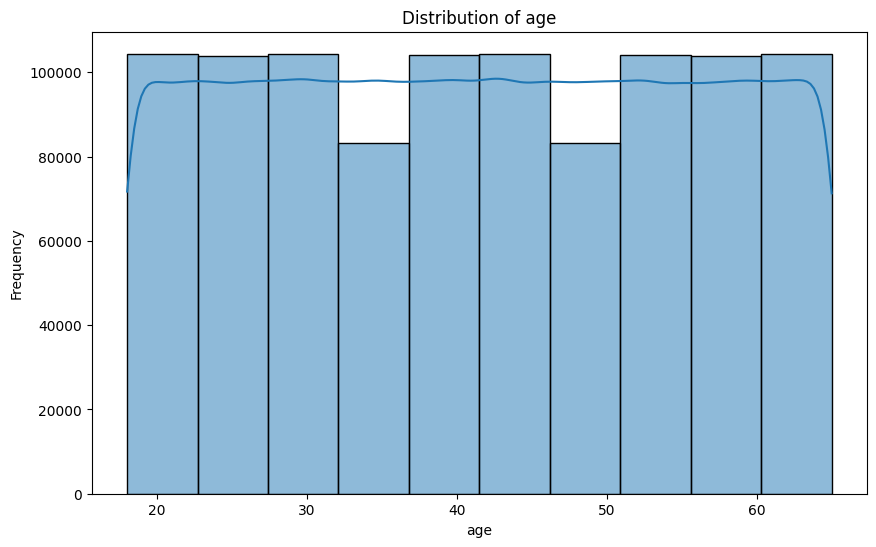

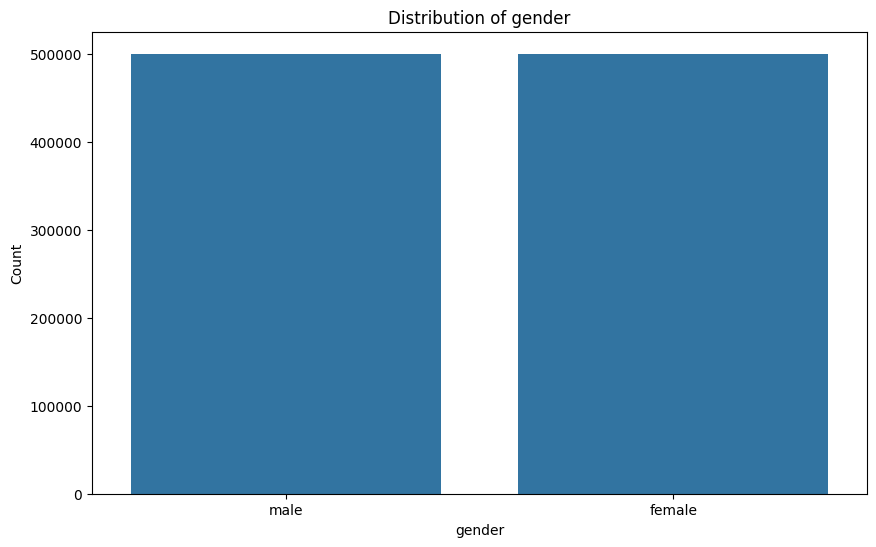

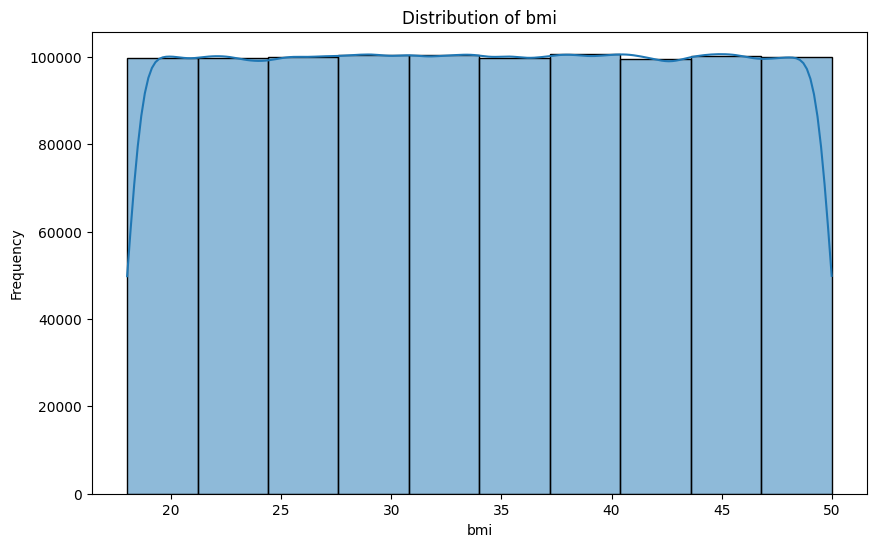

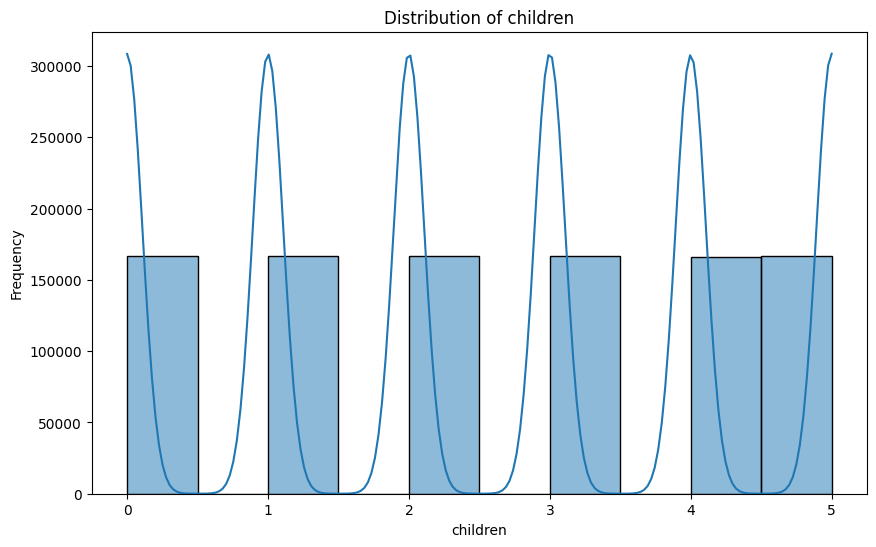

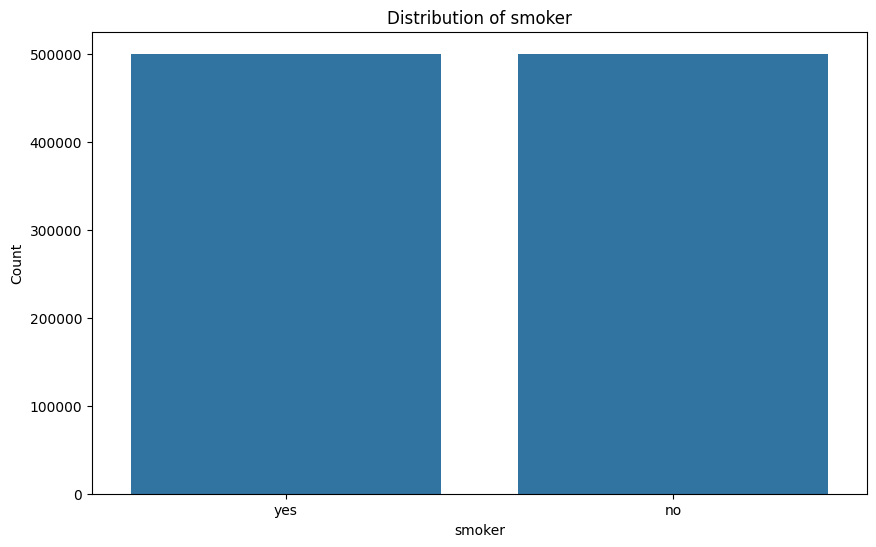

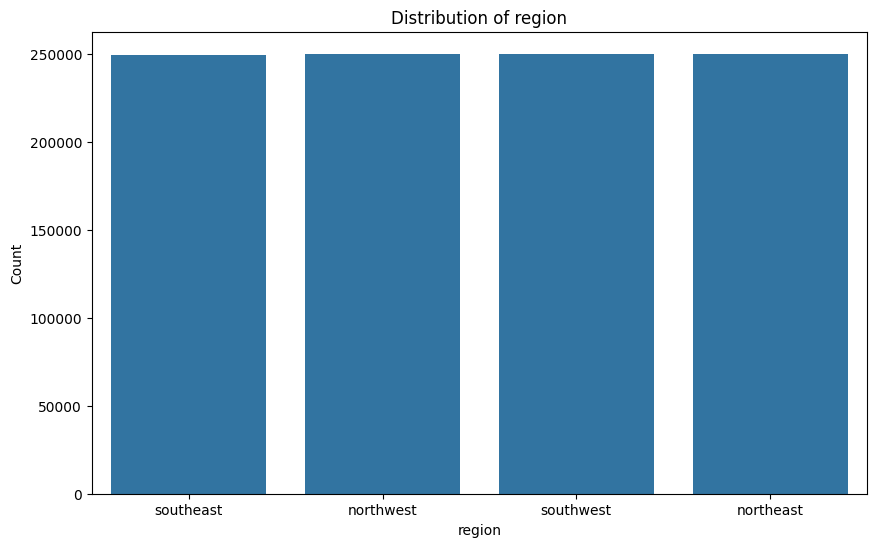

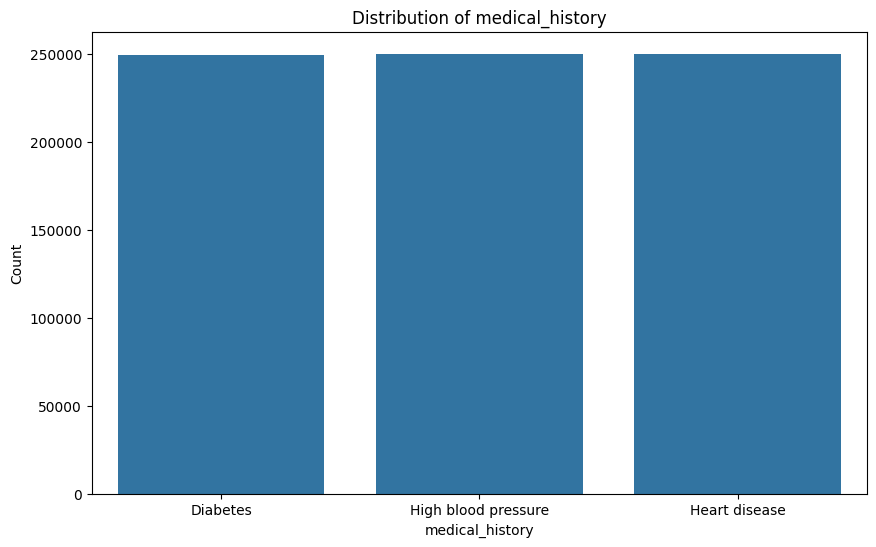

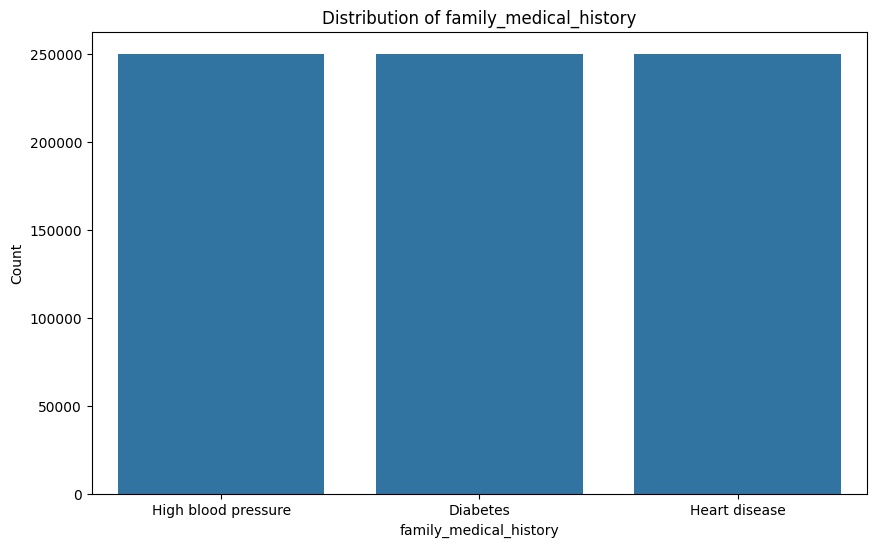

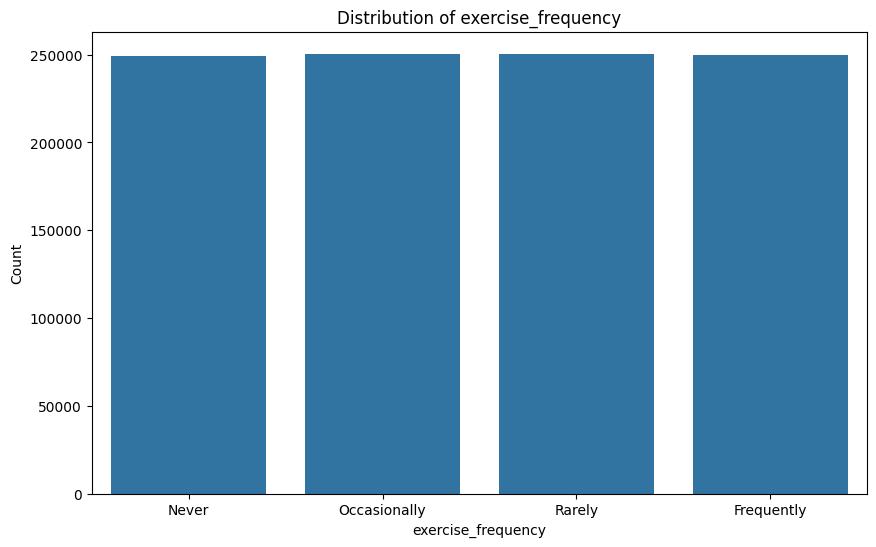

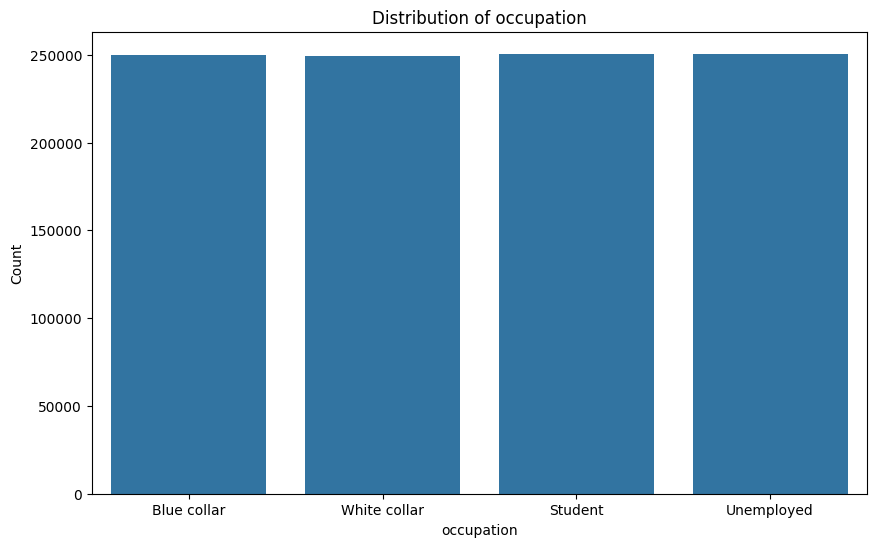

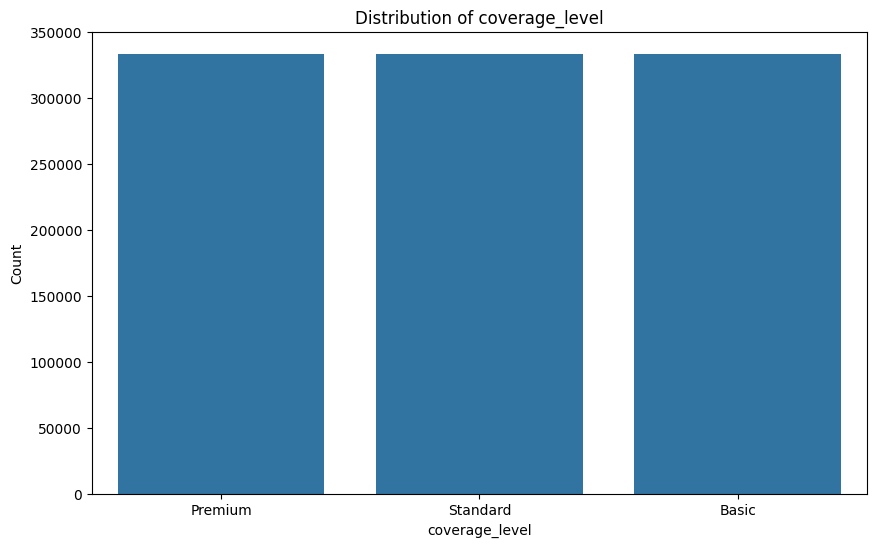

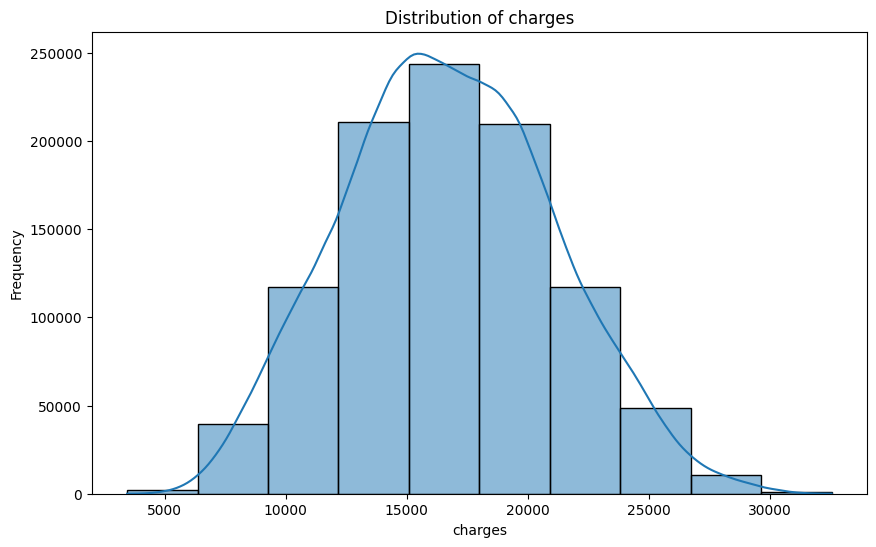

In [16]:
# Melakukan univariate analysis
univariate_analysis(df)

## Bivariate Analysis
Bivariate analysis adalah analisis statistik yang melibatkan dua variabel untuk memahami hubungan atau korelasi antara keduanya.

In [17]:
# Fungsi untuk melakukan bivariate analysis antara kolom lainnya dengan 'charges'
def bivariate_analysis(df, target_column):
    for column in df.columns:
        if column != target_column:
            plt.figure(figsize=(10, 6))

            # Jika kolom adalah numerik, gunakan scatter plot
            if pd.api.types.is_numeric_dtype(df[column]):
                sns.scatterplot(x=column, y=target_column, data=df)
                plt.title(f'Relationship between {column} and {target_column}')
                plt.xlabel(column)
                plt.ylabel(target_column)

            # Jika kolom adalah kategorikal, gunakan boxplot
            elif pd.api.types.is_object_dtype(df[column]):
                sns.boxplot(x=column, y=target_column, data=df)
                plt.title(f'Distribution of {target_column} by {column}')
                plt.xlabel(column)
                plt.ylabel(target_column)
                plt.xticks(rotation=45)

            plt.show()

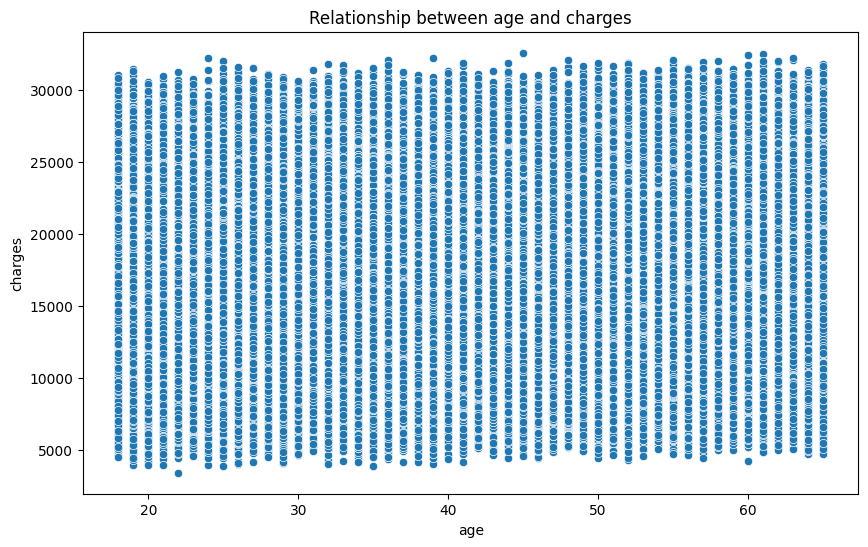

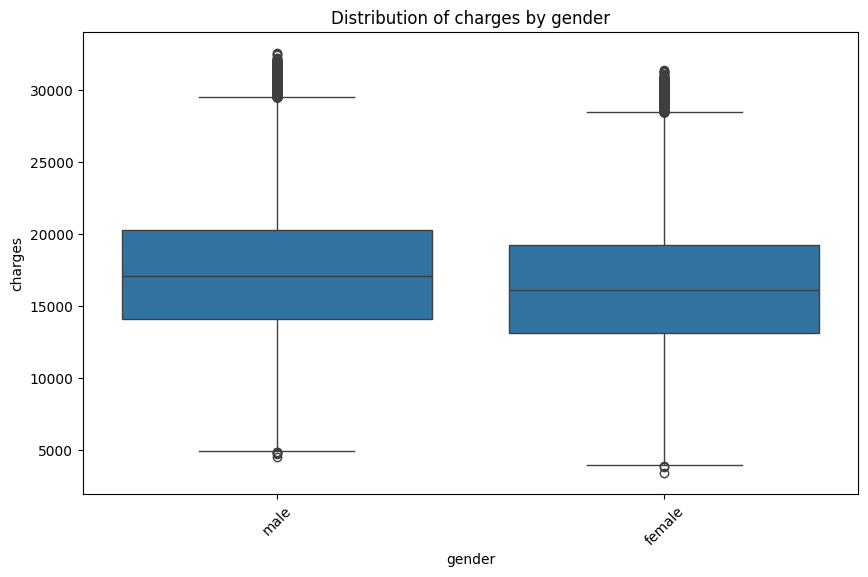

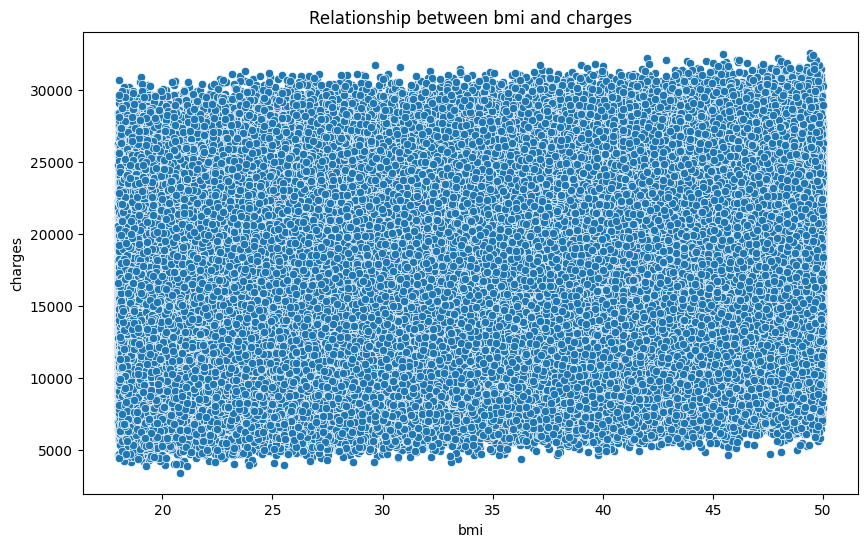

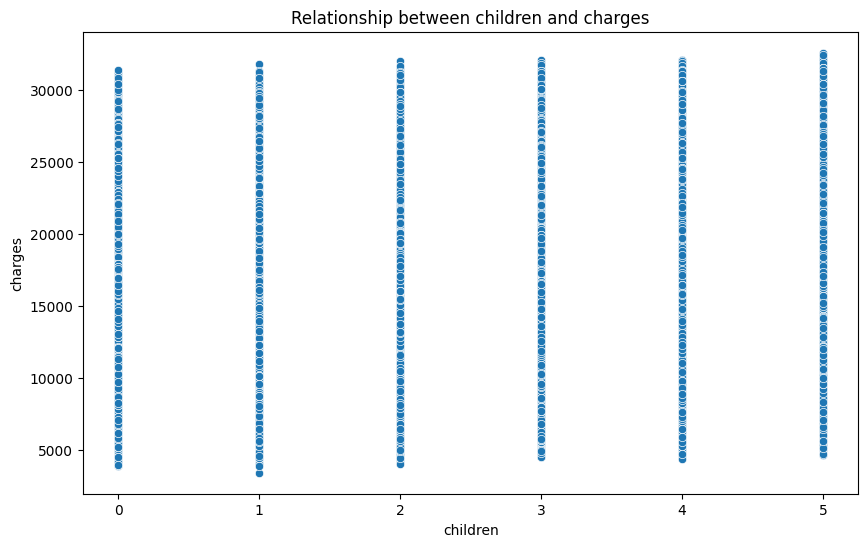

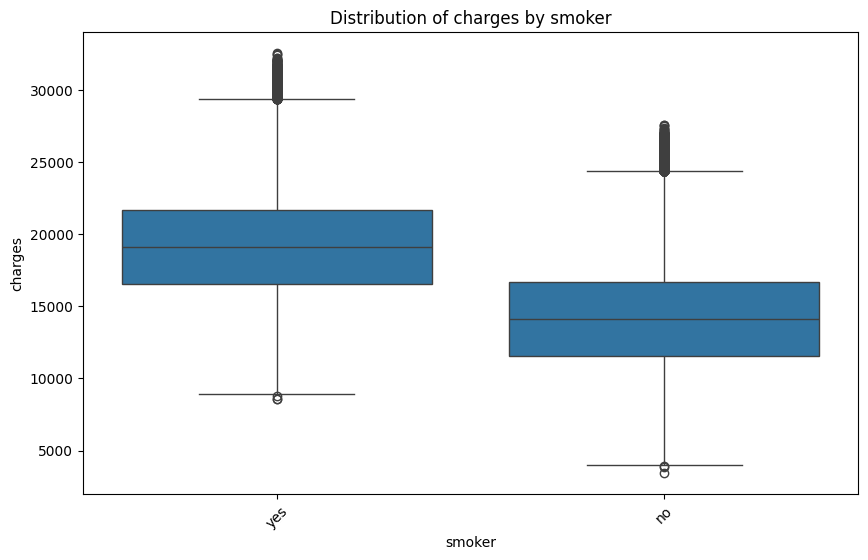

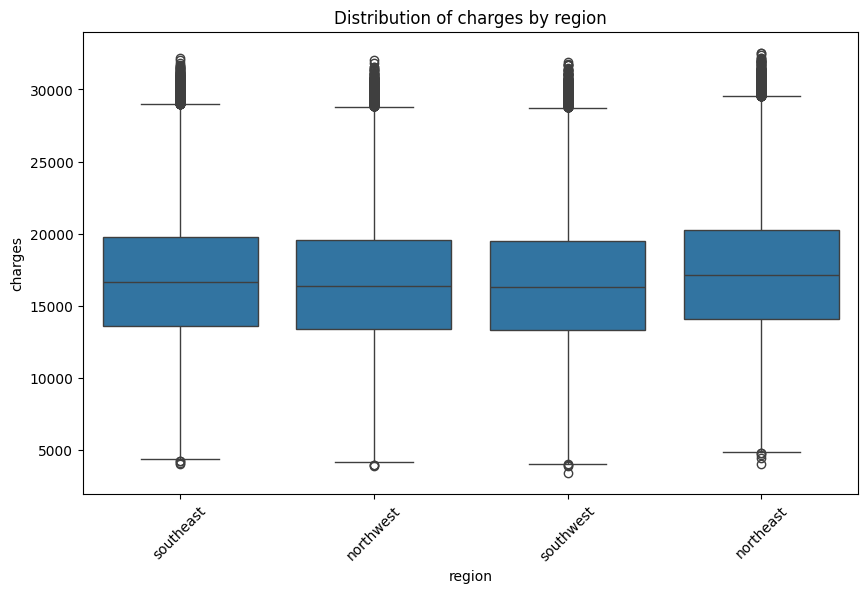

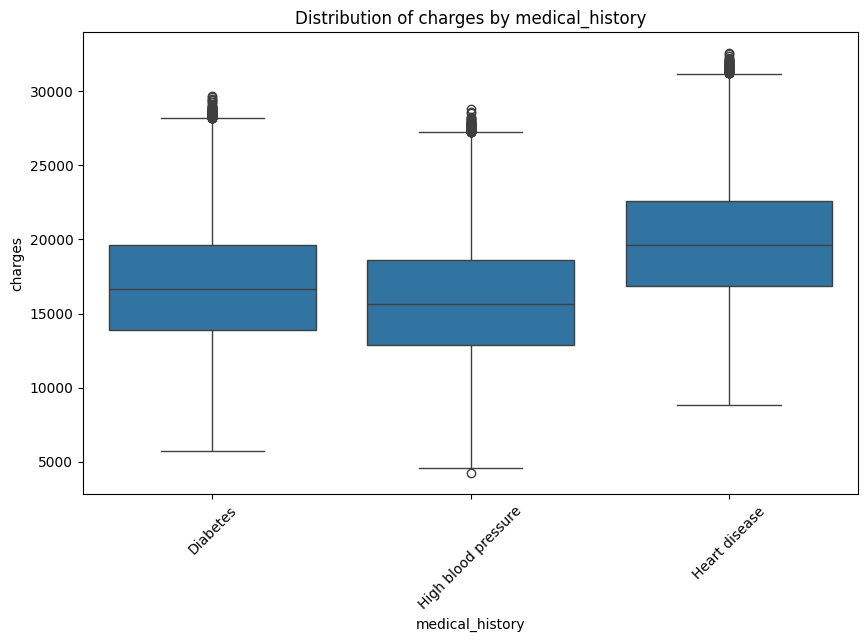

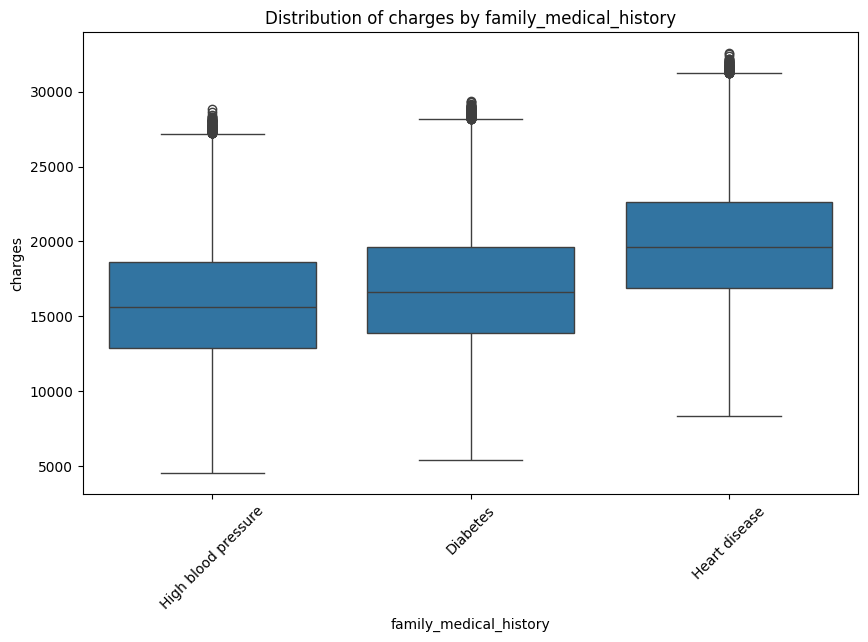

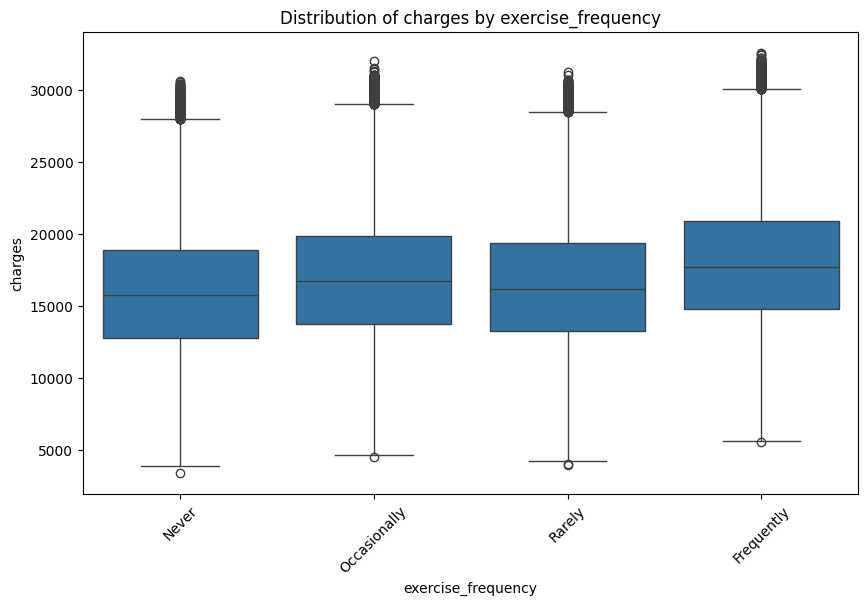

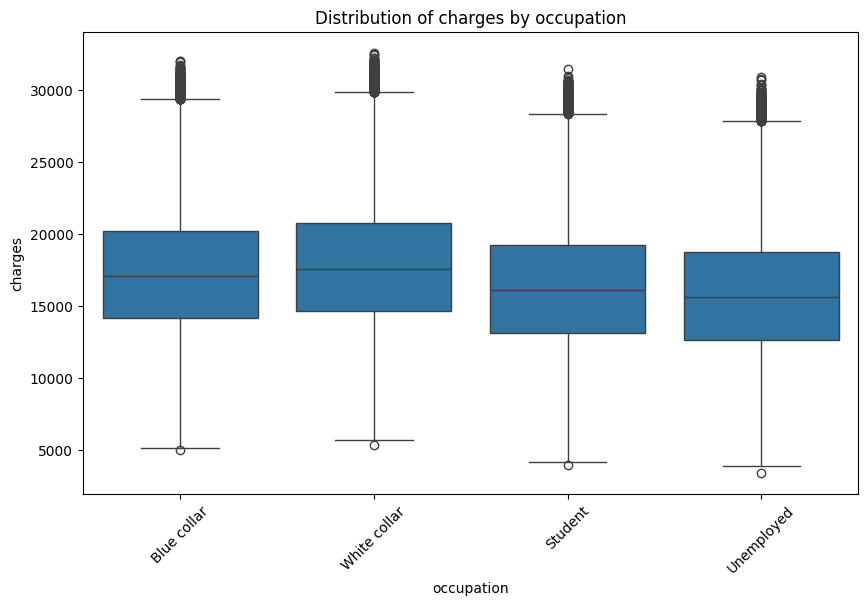

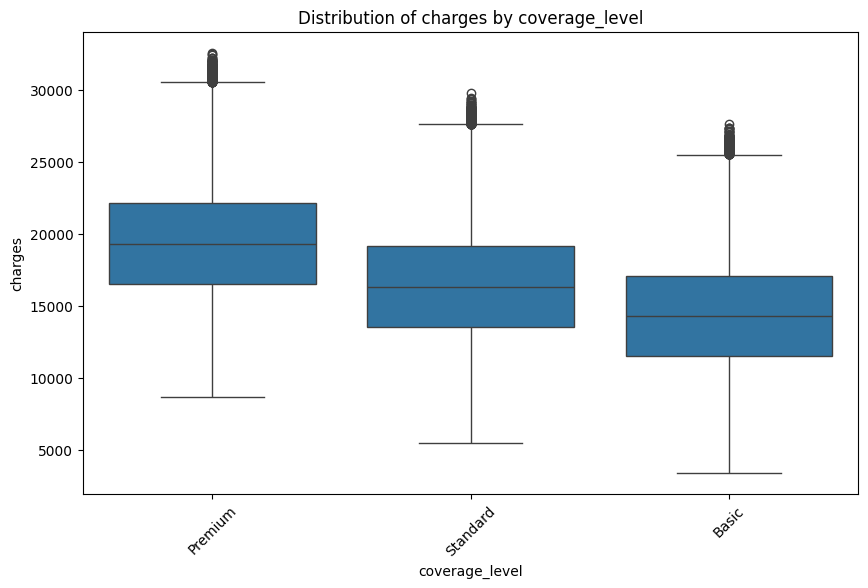

In [18]:
# Melakukan bivariate analysis antara kolom lainnya dengan 'charges'
bivariate_analysis(df, 'charges')

- **Age - Charges**: Titik-titik data tersebar cukup merata, mengindikasikan bahwa Tidak terlihat adanya korelasi linear yang kuat antara usia dan biaya. Artinya, peningkatan usia tidak secara langsung berbanding lurus dengan peningkatan biaya.

- **Gender - Charges**: Baik pria maupun wanita memiliki median biaya yang relatif sama. Ini menunjukkan bahwa secara umum, biaya asuransi kesehatan antara pria dan wanita tidak terlalu berbeda secara signifikan pada titik tengah distribusi data.

- **BMI - Charges**: Titik-titik data tersebar cukup merata, mengindikasikan bahwa Tidak terlihat adanya korelasi linear yang kuat antara BMI dan biaya. Artinya, peningkatan BMI tidak secara langsung berbanding lurus dengan peningkatan biaya.

# Data Preprocessing

## Handling Missing Value

Terdapat 2 kolom yang terdeteksi missing value yaitu kolom medical_history dan
family_medical_history. Saya akan mengganti nilai missing value 'Nan' dengan 'No History' dikarenakan saya berpikir bahwa nilai NaN tersebut mewakili individu yang tidak memiliki riwayat medis pribadi atau keluarga.

In [19]:
# Mengganti NaN dengan 'No History' pada kolom 'medical_history' dan 'family_medical_history'
df['medical_history'].fillna('No History', inplace=True)
df['family_medical_history'].fillna('No History', inplace=True)

In [20]:
# Cek missing value kembali
df.isnull().sum()

,0
age,0
gender,0
bmi,0
children,0
smoker,0
region,0
medical_history,0
family_medical_history,0
exercise_frequency,0
occupation,0


## Encoding

In [21]:
import joblib
# Encoding menggunakan LabelEncoder
df_new = df.copy()
label_encoders = {}

for column in df_new.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_new[column] = le.fit_transform(df_new[column])
    label_encoders[column] = le

# Simpan encoder ke file
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

# Splitting Dataset

In [23]:
X = df_new.drop('charges', axis=1)
y = df_new['charges']

# Membagi dataset menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Trainning

## XGBoost

In [24]:
# Membuat model XGBoost Regressor
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Melatih model dengan data pelatihan
model_xgb.fit(X_train, y_train)

# Membuat prediksi pada data pengujian
y_pred_xgb = model_xgb.predict(X_test)

# Menghitung metrik evaluasi
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Menampilkan hasil
print(f"XGBoost Regressor MSE: {mse_xgb}")
print(f"XGBoost Regressor R^2: {r2_xgb}")

XGBoost Regressor MSE: 120503.16185165636
XGBoost Regressor R^2: 0.993807878146749


In [25]:
# Menghitung MAPE
def calculate_mape(y_true, y_pred):
    # Menghindari pembagian dengan nol
    epsilon = 1e-10
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Menghitung MAPE
mape_xgb = calculate_mape(y_test, y_pred_xgb)

# Menampilkan hasil
print(f"XGBoost Regressor MAPE: {mape_xgb:.2f}%")

XGBoost Regressor MAPE: 1.85%


In [26]:
# Simpan model
joblib.dump(model_xgb, 'xgb_model.pkl')

['xgb_model.pkl']

# Kesimpulan
Performansi Model: Model XGBoost Anda memiliki performa yang sangat tinggi dengan R² yang hampir sempurna dan MAPE yang sangat rendah. Ini menunjukkan bahwa model ini sangat cocok untuk memprediksi biaya asuransi (charges) berdasarkan fitur-fitur yang ada.

In [27]:
# Mengecek nilai unik pada kolom bertipe object
for column in df.select_dtypes(include=['object']).columns:
    print(f"Unique values in '{column}':")
    print(df[column].unique())
    print()

Unique values in 'gender':
['male' 'female']

Unique values in 'smoker':
['yes' 'no']

Unique values in 'region':
['southeast' 'northwest' 'southwest' 'northeast']

Unique values in 'medical_history':
['Diabetes' 'No History' 'High blood pressure' 'Heart disease']

Unique values in 'family_medical_history':
['No History' 'High blood pressure' 'Diabetes' 'Heart disease']

Unique values in 'exercise_frequency':
['Never' 'Occasionally' 'Rarely' 'Frequently']

Unique values in 'occupation':
['Blue collar' 'White collar' 'Student' 'Unemployed']

Unique values in 'coverage_level':
['Premium' 'Standard' 'Basic']



In [34]:
# Kolom yang tidak ingin ditampilkan nilainya
exclude_columns = ['age', 'bmi', 'children', 'charges']

# Menampilkan nilai unik untuk kolom kecuali kolom yang di-exclude
for column in df_new.columns:
    if column not in exclude_columns:
        print(f"Unique values in '{column}':")
        print(df_new[column].unique())
        print()

Unique values in 'gender':
[1 0]

Unique values in 'smoker':
[1 0]

Unique values in 'region':
[2 1 3 0]

Unique values in 'medical_history':
[0 3 2 1]

Unique values in 'family_medical_history':
[3 2 0 1]

Unique values in 'exercise_frequency':
[1 2 3 0]

Unique values in 'occupation':
[0 3 1 2]

Unique values in 'coverage_level':
[1 2 0]



In [32]:
# Muat encoder dan model dari file
label_encoders = joblib.load('label_encoders.pkl')
model_xgb = joblib.load('xgb_model.pkl')

# Data baru
input_data = {
    'age': [34],
    'gender': ['male'],
    'bmi': [19.89],
    'children': [1],
    'smoker': ['no'],
    'region': ['southwest'],
    'medical_history': ['No History'],
    'family_medical_history': ['High blood pressure'],
    'exercise_frequency': ['Frequently'],
    'occupation': ['Unemployed'],
    'coverage_level': ['Basic']
}

# Membuat DataFrame dari data baru
df_input = pd.DataFrame(input_data)

# Transformasi data baru menggunakan encoder
for column in df_input.select_dtypes(include=['object']).columns:
    if column in label_encoders:
        # Buat mapping dari nilai asli ke encoded
        mapping = dict(zip(label_encoders[column].classes_, label_encoders[column].transform(label_encoders[column].classes_)))
        df_input[column] = df_input[column].map(mapping).fillna(-1).astype(int)

# Tangani nilai yang tidak dikenal jika ada
df_input.fillna(-1, inplace=True)

# Buat prediksi menggunakan model XGBoost
y_pred_input = model_xgb.predict(df_input)

print(f"Prediksi untuk data baru: {y_pred_input[0]}")


Prediksi untuk data baru: 8191.052734375


In [35]:
df_input

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level
0,34,1,19.89,1,0,3,3,2,0,2,0
